In [1]:
%run ../widgets/config_check.py

In [9]:
# <api>
import numpy as np
from scipy.stats import norm, multivariate_normal
from scipy.special import logsumexp
from matplotlib import pyplot as plt
%matplotlib inline

# Load classes and functions from the previous parts
from jupyter_cms.loader import load_notebook
smpl_intro = load_notebook('./Sampling_Intro.ipynb')
smpl_rej = load_notebook('./Sampling_Rejection.ipynb')
smpl_index = load_notebook('./Sampling_Index.ipynb')

In [10]:
smpl_index.help()

# Hamiltonian Monte Carlo (HMC)

HMC uses gradient information to automatically find suitable directions. In this sense it fixes the above shortcoming that we have to specify a suitable proposal distribution in Metropolis-Hastings or adapted directions in multi-variate slice sampling. HMC makes clever use of a physical analogy and augments the state space with an auxiliary momentum vector $\mathbf{p}$.

Write the probability density $p(x)$ as
$$ p(x) = \frac{1}{Z} e^{-E(x)} $$
and assume that the *energy* $E(x)$ as well as its gradient with respect to $x$ can be evaluated. Note that any $p(x)$ can be written in the above form by choosing $E(x) = - \log p(x)$.

Now, define the Hamiltonian $H(x) = E(x) + K(\mathbf{p})$, i.e. the total (potential $E(x)$ plus kinetic $K(\mathbf{p}) = \frac{1}{2} \mathbf{p}^t \mathbf{p}$) energy of the system. It is well known from physics that the following dynamics conserves energy
$$ \begin{array}{lcl} \dot{x} & = & \mathbf{p} \\ \dot{\mathbf{p}} & = & - \frac{\partial}{\partial x} E(x) \end{array} $$

Thus, we can sample from the joint density $p(x,\mathbf{p}) \propto e^{E(x)} e^{K(\mathbf{p})}$ using Gibbs-like steps:

1. Sample $\mathbf{p} \sim p(\mathbf{p}|x) = \mathcal{N}(0, \mathbb{1})$
2. Produce new state $x'$ by simulating the Hamiltonian dynamics for some time. Due to energy conservation the proposed $x'$ will always be accepted.

Also volume is preserved by the Hamiltonian dynamics. This simplifies the algorithm considerably as no Jacobian adjustment is necessary to account for the change in volume.

In [3]:
# <api>
def integrate_H(xp, dE_dx, T, dt, method='euler'):
    """
    Integrate the state xp for some time with the Hamiltonian H(x) = E(x) + K(x) 
    """
    x,p = xp
    t = 0
    while (t < T):
        t += dt
        if method=='euler':
            gradE = dE_dx(x)
            x += p*dt
            p += - gradE*dt
        else:
            error('Unknown integratin method')
    return x,p

Unfortunately, Euler integration is very unstable for the Hamiltonian dynamics. Further, to ensure detailed balance we need to make sure that the integration scheme is reversible. In practice, a leap-frog integration is applied where half steps to the momentum are interleaved with an update to the state. In addition, leap-frog integration leads to a deterministic, discrete dynamics that is exactly invertible and preserves volume (as each update changes one variable based on the state of the other variable only, i.e. it is a simple shift in each variable).

In [4]:
# <api>
def integrate_H(xp, dE_dx, T, dt, method='leap_frog'):
    """
    Integrate the state xp for some time with the Hamiltonian H(x) = E(x) + K(x) 
    """
    x,p = np.copy(xp)
    t = 0
    while (t < T):
        t += dt
        if method=='euler':
            gradE = dE_dx(x)
            x += p*dt
            p += - gradE*dt
        elif method=='leap_frog':
            p += - dE_dx(x)*dt/2
            x += p*dt
            p += - dE_dx(x)*dt/2
        else:
            error('Unknown integratin method')
    return x,p

Demonstration on the 2-dimensional Gaussian example:

In [5]:
# <api>
# Simple numeric differentiation
def grad (f, x):
    eps = 1e-4
    gradx = np.zeros_like(x)
    for i in range(x.size):
        dx = np.zeros_like(x)
        dx[i] = 1
        gradx[i] = (f(x + dx*eps/2) - f(x - dx*eps/2))/eps
    return gradx

def dE2d_dx(x):
    return grad(lambda x: - smpl_rej.p2d.logpdf(x), x)

x0 = np.array([1.5, 0]); p0 = np.array([0.1, -0.1])
traj_euler = [(x0,p0)]; traj_leap_frog = [(x0,p0)]
dt = 0.01
for i in range(250):
    traj_euler.append(integrate_H(traj_euler[-1], dE2d_dx, dt, dt, 'euler'))
    traj_leap_frog.append(integrate_H(traj_leap_frog[-1], dE2d_dx, dt, dt, 'leap_frog'))
traj_euler = np.array(traj_euler).squeeze(); traj_leap_frog = np.array(traj_leap_frog).squeeze()

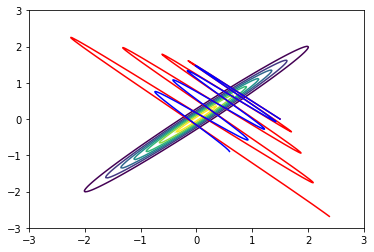

In [6]:
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));
plt.plot(traj_euler[:,0,0], traj_euler[:,0,1], 'r-')
plt.plot(traj_leap_frog[:,0,0], traj_leap_frog[:,0,1], 'b-');
plt.axis([-3,3,-3,3]);

In practice, also the leap frog integration is not perfect and energy is not precisely conserved. Thus, the actual algorithm includes a Metropolis step which discards samples with lower energy to ensure that it samples from the correct distribution.

In [7]:
# <api>
class HMC (smpl_intro.Sampling):
    def __init__(self, x, E, dE_dx=None, Tau=42, dtau=0.04):
        self.x = x
        self.E = E
        if dE_dx is None:
            dE_dx = lambda x: grad(E, x)
        self.dE_dx = dE_dx
        self.Tau = Tau
        self.dtau = dtau
        
    def _H (self, x, p):
        return self.E(x) + 0.5*np.dot(p.T, p)
        
    def sample (self):
        # Gibbs step for momentum
        x = self.x
        p = np.random.normal(size=x.shape)
        H = self._H(x, p)
        
        # Simulate dynamics
        xnew, pnew = integrate_H((x,p), self.dE_dx, self.Tau*self.dtau, self.dtau, 'leap_frog')
        Hnew = self._H(xnew, pnew)
        
        # Metropolis step
        if np.log(np.random.uniform()) < H - Hnew: # Remember: H = - logp
            self.x = xnew
        return self.x

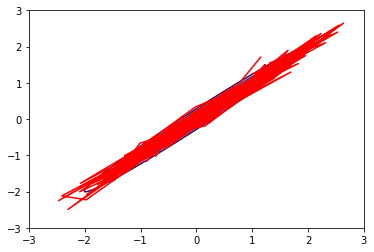

In [8]:
sampling = HMC(np.array([1.5,0]), lambda x: - smpl_rej.p2d.logpdf(x))

samples = [sampling.sample() for _ in range(250)]
plt.plot(np.array(samples)[:,0], np.array(samples)[:,1], 'r-')
plt.contour(smpl_rej.X, smpl_rej.Y, smpl_rej.p2d.pdf(smpl_rej.XY));